Homework 3

In [1075]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from ISLP import confusion_table
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import \
     (KMeans,
      AgglomerativeClustering)
from scipy.cluster.hierarchy import \
     (dendrogram,
      cut_tree)
from ISLP.cluster import compute_linkage
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions
from math import e, log, sqrt


1. Logistic Regression

In [1076]:
B0, B1, B2 = -4.2, 0.04, 0.8
X1, X2 = 60, 2
Y = B0 + B1*X1 + B2*X2

p = (e**Y)/(1+(e**Y))
print('Probability of admission:', p)

Probability of admission: 0.45016600268752205


In [1077]:
p = 0.9
X1 = (log(p/(1-p)) - B0 - B2*X2) / B1
print(round(X1,2), 'practice hours')

119.93 practice hours


In [1078]:
Y = B0
p = (e**Y)/(1+(e**Y))
print(p)

0.014774031693273059


-4.2 is the intercept when the hours of coding practice and years of programming experience are both 0. This is equivalent to an admission probability of 1.48%.

2. Orange Juice

In [1079]:
OJ = load_data('OJ')
OJ.columns

Index(['Purchase', 'WeekofPurchase', 'StoreID', 'PriceCH', 'PriceMM', 'DiscCH',
       'DiscMM', 'SpecialCH', 'SpecialMM', 'LoyalCH', 'SalePriceMM',
       'SalePriceCH', 'PriceDiff', 'Store7', 'PctDiscMM', 'PctDiscCH',
       'ListPriceDiff', 'STORE'],
      dtype='object')

In [1080]:
train_mask = OJ['StoreID'] != 7
OJ_train = OJ[train_mask]
test_mask = OJ['StoreID'] == 7
OJ_test = OJ[test_mask]

predictors = ['LoyalCH', 'SpecialCH', 'PriceDiff']
X_train = OJ_train[predictors]
X_test = OJ_test[predictors]

y_train = OJ_train['Purchase']
y_test = OJ_test['Purchase']

# convert categorical target variable to binary
y_train = y_train.map({'MM': 0, 'CH': 1})
y_test = y_test.map({'MM': 0, 'CH': 1})

Train = pd.merge_ordered(X_train,y_train,left_on=X_train.index,right_on=y_train.index).drop(columns=['key_0'])
Test = pd.merge_ordered(X_test,y_test,left_on=X_test.index,right_on=y_test.index).drop(columns=['key_0'])

In [1081]:
for column in predictors:
    col = Train[column]
    mean = round(col.mean(), 4)
    sd = round(col.std(), 4)
    median = col.median()
    min = col.min()
    max = col.max()
    print(f'{column}, mean: {mean}, sd: {sd}, median: {median}, min: {min}, max: {max}')

LoyalCH, mean: 0.52, sd: 0.3138, median: 0.5, min: 1.1e-05, max: 0.999947
SpecialCH, mean: 0.0462, sd: 0.2101, median: 0.0, min: 0, max: 1
PriceDiff, mean: 0.1145, sd: 0.2559, median: 0.2, min: -0.67, max: 0.44


In [1082]:
X_train.corr()

,LoyalCH,SpecialCH,PriceDiff
LoyalCH,1.000000,0.014230,0.008349
SpecialCH,0.014230,1.000000,-0.025542
PriceDiff,0.008349,-0.025542,1.000000


In [1083]:
# We'll need to add an intercept column to our X dataframes

X_train['intercept'] = np.ones(X_train.shape[0])
X_test['intercept'] = np.ones(X_test.shape[0])
X_train

C:\Users\aidik\AppData\Local\Temp\ipykernel_14492\425660585.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['intercept'] = np.ones(X_train.shape[0])
C:\Users\aidik\AppData\Local\Temp\ipykernel_14492\425660585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['intercept'] = np.ones(X_test.shape[0])


,LoyalCH,SpecialCH,PriceDiff,intercept
0,0.500000,0,0.24,1.0
1,0.600000,0,-0.06,1.0
2,0.680000,0,0.40,1.0
3,0.400000,0,0.00,1.0
16,0.500000,0,-0.06,1.0
...,...,...,...,...
1059,0.619072,0,0.30,1.0
1060,0.695258,0,0.24,1.0
1061,0.556206,0,-0.17,1.0
1063,0.355972,0,0.33,1.0


In [1084]:
# Run the logistic regression model

glm = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
LoyalCH,6.3847,0.456,14.009,0.00
SpecialCH,-0.1841,0.447,-0.412,0.68
PriceDiff,2.5697,0.426,6.038,0.00
intercept,-3.4069,0.267,-12.756,0.00


Citrus Hill Loyalty and Price Difference are statistically significant due to their low p-values.

In [1085]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

In [1086]:
# Get the predicted probabilities

probs_train=predict(X_train,results)

In [1087]:
# We'll use 0.5 as the threshold for True vs. False

predictions_train = np.array([True]*len(y_train))
predictions_train[probs_train<0.5] = False

In [1088]:
confusion_table(predictions_train, y_train)

Truth,0,1
Predicted,,
0,269,62
1,66,317


The fraction of overall correct predictions is 586/714. 66 of the 335 negative values were false positives, so the false positive rate is ~19.7%. 62 of 379 positive values were false negatives, so the false negative rate is ~16.4%.

In [1089]:
X_train = X_train.drop('SpecialCH', axis=1)
X_test = X_test.drop('SpecialCH', axis=1)

In [1090]:
# Run the logistic regression model

glm = sm.GLM(y_train,
             X_train,
             family=sm.families.Binomial())
results = glm.fit()
summarize(results)

,coef,std err,z,P>|z|
LoyalCH,6.3811,0.456,14.008,0.0
PriceDiff,2.5729,0.426,6.043,0.0
intercept,-3.4159,0.266,-12.820,0.0


In [1091]:
# Get the predicted probabilities

probs_test=predict(X_test,results)

In [1092]:
predictions_test = np.array([True]*len(y_test))
predictions_test[probs_test<0.5] = False

In [1093]:
confusion_table(predictions_test, y_test)

Truth,0,1
Predicted,,
0,60,34
1,22,240


The fraction of overall correct predictions is 300/356. 22 of the 82 negative values were false positives, so the false positive rate is ~26.8%. 34 of 274 positive values were false negatives, so the false negative rate is ~12.4%.

In [1094]:
# Build the model

nb = GaussianNB()
nb.fit(X_train, y_train)

,priors,None
,var_smoothing,1e-09


In [1095]:
# get predictions and construct confusion matrix on test data

nb_test = nb.predict(X_test)
confusion_table(nb_test, y_test)

Truth,0,1
Predicted,,
0,64,39
1,18,235


Correct predictions: 299/356

False positve rate: 18/82 ~22.0%

False negative rate: 39/274 ~14.2%

In [1096]:
# kNN requires an array as input, so we'll make copies of the train and test X's

X_train_knn, X_test_knn = [np.asarray(X) for X in [X_train, X_test]]

In [1097]:
# First we'll try using only the nearest neighbor (k=5)
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5.fit(X_train_knn, y_train)
knn5_test = knn5.predict(X_test_knn)

confusion_table(knn5_test, y_test)

Truth,0,1
Predicted,,
0,60,47
1,22,227


Correct predictions: 287/356

False positve rate: 22/82 ~26.8%

False negative rate: 47/274 ~17.2%

In [1098]:
# k=50
knn50 = KNeighborsClassifier(n_neighbors=50)
knn50.fit(X_train_knn, y_train)
knn50_test = knn50.predict(X_test_knn)

confusion_table(knn50_test, y_test)

Truth,0,1
Predicted,,
0,63,42
1,19,232


Correct predictions: 295/356

False positve rate: 19/82 ~23.2%

False negative rate: 42/274 ~15.3%

In [1099]:
# k = 150
knn150 = KNeighborsClassifier(n_neighbors=150)
knn150.fit(X_train_knn, y_train)
knn150_test = knn150.predict(X_test_knn)

confusion_table(knn150_test, y_test)

Truth,0,1
Predicted,,
0,60,39
1,22,235


Correct predictions:295/356

False positve rate: 22/82 ~26.8%

False negative rate: 39/274 ~14.2

c:\Users\aidik\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\aidik\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\aidik\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(
c:\Users\aidik\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
c:\Users\aidik\anaconda3\envs\islp\Lib\site-packages\sklearn\utils\_plot

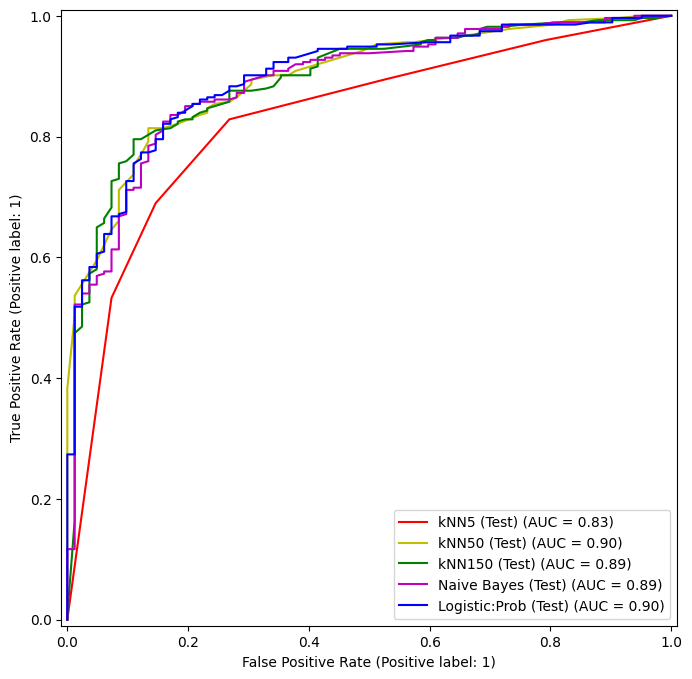

In [1100]:
fig, ax = subplots(figsize=(8,8))
roc_curve_est(knn5,
              X_test_knn,
              y_test,
              name='kNN5 (Test)',
              color='r',
              ax=ax)

roc_curve_est(knn50,
              X_test_knn,
              y_test,
              name='kNN50 (Test)',
              color='y',
              ax=ax)

roc_curve_est(knn150,
              X_test_knn,
              y_test,
              name='kNN150 (Test)',
              color='g',
              ax=ax)

roc_curve_est(nb,
              X_test_knn,
              y_test,
              name='Naive Bayes (Test)',
              color='m',
              ax=ax)

roc_curve_pred(y_test,
               probs_test,
               name='Logistic:Prob (Test)',
               color='b',
               ax=ax);

The kNN50 and Logistic models both have an AUC of 0.90

3. K-means clustering

In [1101]:
data = [
    [1,4],
    [1,3],
    [0,4],
    [5,1],
    [6,2],
    [4,0]
]

obs = pd.DataFrame(data, columns=['X1', 'X2'])
obs

,X1,X2
0,1,4
1,1,3
2,0,4
3,5,1
4,6,2
5,4,0


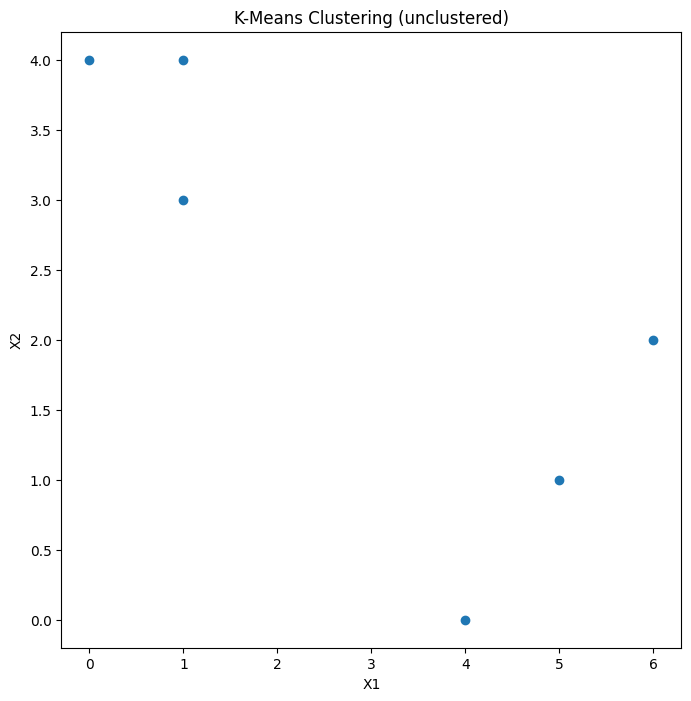

In [1102]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(obs['X1'], obs['X2'])
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title("K-Means Clustering (unclustered)");

In [1103]:

labels = [1,1,2,2,3,3]

array = np.array(labels)
np.random.shuffle(array)
random_labels = array.tolist()

obs['cluster'] = random_labels
obs

,X1,X2,cluster
0,1,4,2
1,1,3,1
2,0,4,3
3,5,1,3
4,6,2,2
5,4,0,1


In [1104]:
def calc_cluster():
    c1_mask = obs['cluster'] == 1
    c1 = obs[c1_mask]
    c2_mask = obs['cluster'] == 2
    c2 = obs[c2_mask]
    c3_mask = obs['cluster'] == 3
    c3 = obs[c3_mask]
    return c1, c2, c3

In [1105]:
def calc_centroids(c1, c2, c3):
    c1x = c1['X1'].mean()
    c1y = c1['X2'].mean()
    c2x = c2['X1'].mean()
    c2y = c2['X2'].mean()
    c3x = c3['X1'].mean()
    c3y = c3['X2'].mean()
    X1 = [c1x, c2x, c3x]
    X2 = [c1y, c2y, c3y]
    return X1, X2

In [1106]:
def distance(x1, y1, x2, y2):
    return sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [1107]:
def update_clusters(X1, X2):
    cluster_list = []
    for row in obs.itertuples(index=False):
        cluster = row.cluster
        short_dist = float('inf')
        for i in range(3):
            dist = distance(row.X1, row.X2, X1[i], X2[i])
            if dist < short_dist:
                short_dist = dist
                cluster = i + 1
        cluster_list.append(cluster)
    obs['cluster'] = cluster_list


In [1108]:
def k_means():
    clusters1 = obs['cluster']
    c1, c2, c3 = calc_cluster()
    X1, X2 = calc_centroids(c1, c2, c3)
    update_clusters(X1, X2)
    clusters2 = obs['cluster']
    if clusters1.equals(clusters2):
        return
    else: k_means()

In [1109]:
k_means()
obs

,X1,X2,cluster
0,1,4,3
1,1,3,3
2,0,4,3
3,5,1,2
4,6,2,2
5,4,0,1


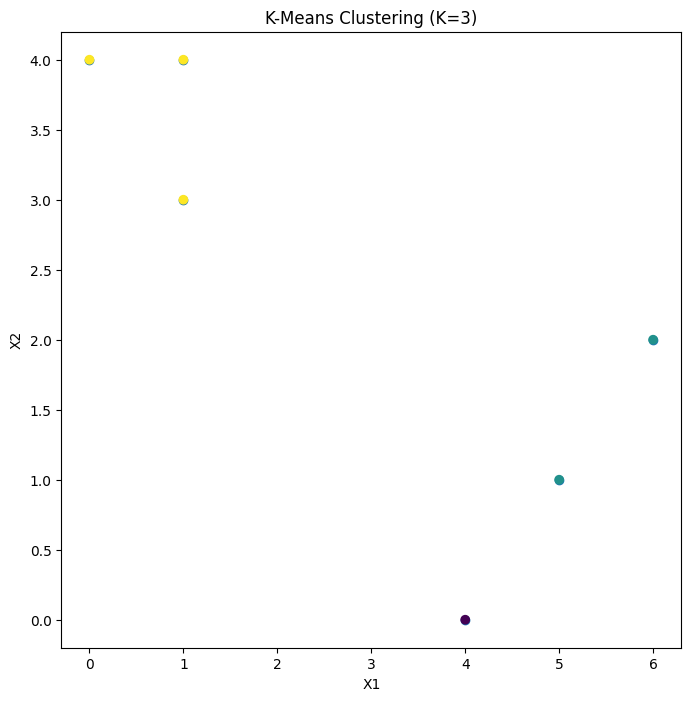

In [1110]:
ax.scatter(obs['X1'], obs['X2'], c=obs['cluster'])
ax.set_title("K-Means Clustering (K=3)")
fig

4. Americorps

In [1111]:
cev = pd.read_csv('../data/CEV2021.csv')
cev.index = cev['State']
cev.drop(columns='State', axis=1, inplace=True)

In [1112]:
# Let's do an initial clustering exercise on the data as is

HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(cev)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,0
,compute_distances,False


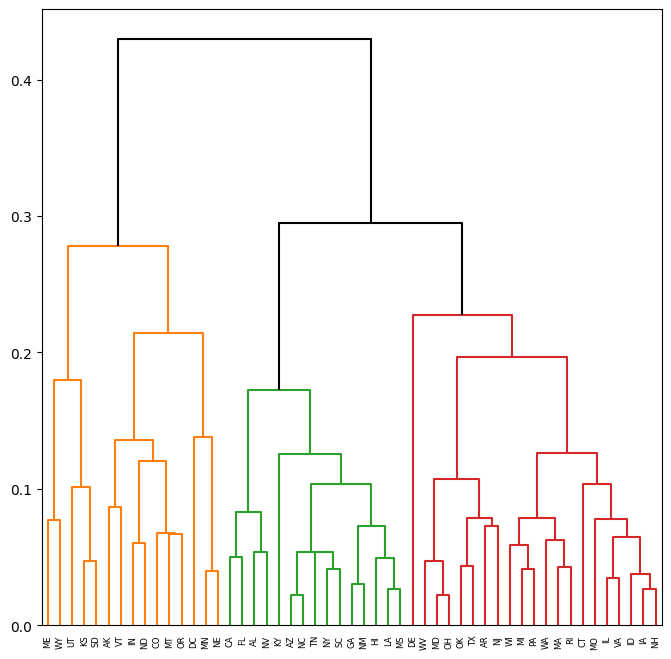

In [1113]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           leaf_rotation=90,
           labels=cev.index,
           color_threshold=0.29,
           above_threshold_color='black');

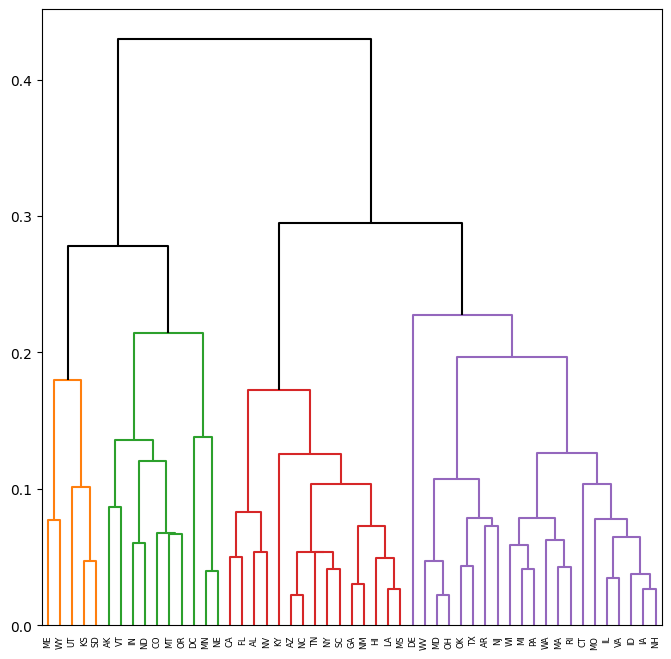

In [1114]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           leaf_rotation=90,
           labels=cev.index,
           color_threshold=0.25,
           above_threshold_color='black');

In [1115]:
# Run a single K-means with K=3

kmeans = KMeans(n_clusters=3,
                random_state=1,
                n_init=1).fit(cev)

In [1116]:
# Get the cluster assignments 

cluster_km = pd.DataFrame(kmeans.labels_)
cluster_km.index=cev.index

In [1128]:
# Add the cluster assignments to the data

cev['cluster_km']=cluster_km
print(cev['cluster_km'].sort_values())

State
CT    0
DE    0
IN    0
IA    0
ID    0
IL    0
MA    0
KS    0
MO    0
MI    0
NH    0
VA    0
SD    0
WA    0
RI    0
PA    0
WI    0
NM    1
NJ    1
FL    1
CA    1
LA    1
MD    1
KY    1
MS    1
NY    1
NV    1
AR    1
GA    1
HI    1
AL    1
AZ    1
TX    1
TN    1
OH    1
SC    1
WV    1
NC    1
OK    1
DC    2
MT    2
NE    2
ME    2
MN    2
CO    2
AK    2
OR    2
ND    2
UT    2
VT    2
WY    2
Name: cluster_km, dtype: int32


In [1118]:
# Standardize the data before clustering

scaler = StandardScaler()
cev_scale = scaler.fit_transform(cev)

HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(cev_scale)

,n_clusters,None
,metric,'euclidean'
,memory,None
,connectivity,None
,compute_full_tree,'auto'
,linkage,'complete'
,distance_threshold,0
,compute_distances,False


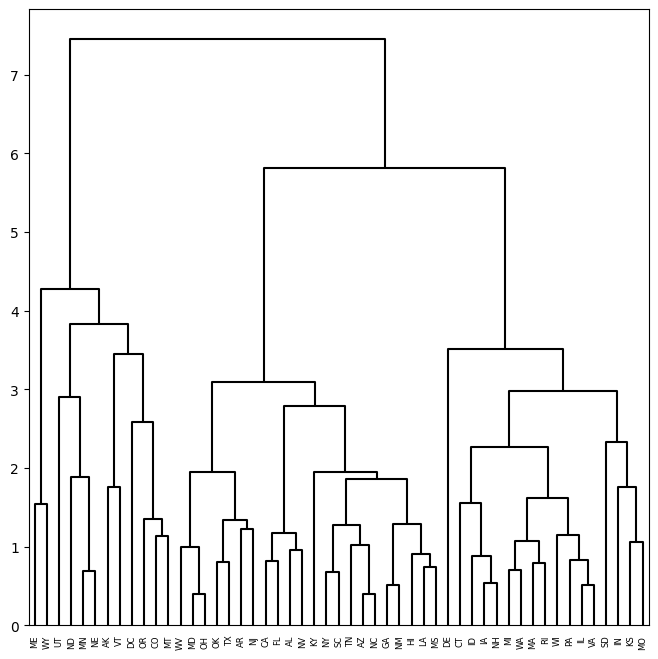

In [1119]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           leaf_rotation=90,
           labels=cev.index,
           color_threshold=0.29,
           above_threshold_color='black');

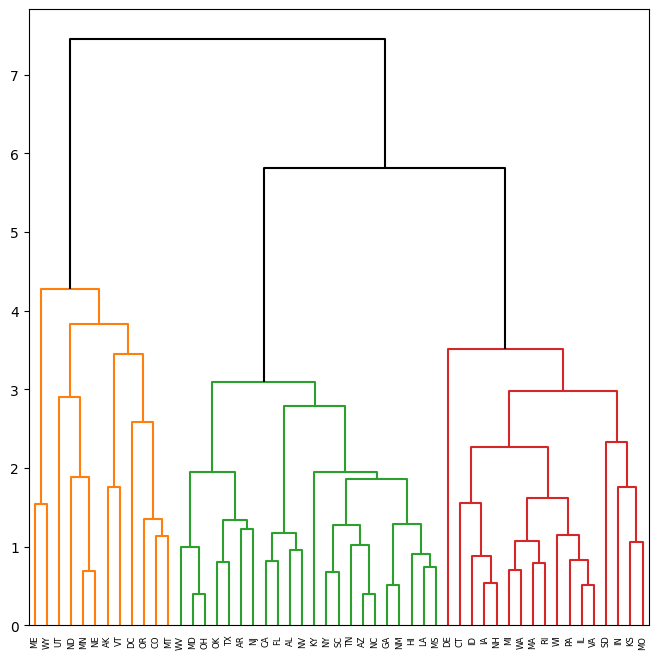

In [1120]:
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           leaf_rotation=90,
           labels=cev.index,
           color_threshold=5,
           above_threshold_color='black');

In [1121]:
# Run K-means with K=3

kmeans = KMeans(n_clusters=3,
                random_state=1,
                n_init=1).fit(cev_scale)

In [1122]:
# Get the cluster assignments 

cluster_km_z = pd.DataFrame(kmeans.labels_)
cluster_km_z.index=cev.index

In [1129]:
# Add the cluster assignments to the data

cev['cluster_km_z']=cluster_km_z
print(cev['cluster_km_z'].sort_values())

State
CT    0
DE    0
IN    0
IA    0
ID    0
IL    0
MA    0
KS    0
MO    0
MI    0
NH    0
VA    0
SD    0
WA    0
RI    0
PA    0
WI    0
NM    1
NJ    1
FL    1
CA    1
LA    1
MD    1
KY    1
MS    1
NY    1
NV    1
AR    1
GA    1
HI    1
AL    1
AZ    1
TX    1
TN    1
OH    1
SC    1
WV    1
NC    1
OK    1
DC    2
MT    2
NE    2
ME    2
MN    2
CO    2
AK    2
OR    2
ND    2
UT    2
VT    2
WY    2
Name: cluster_km_z, dtype: int32


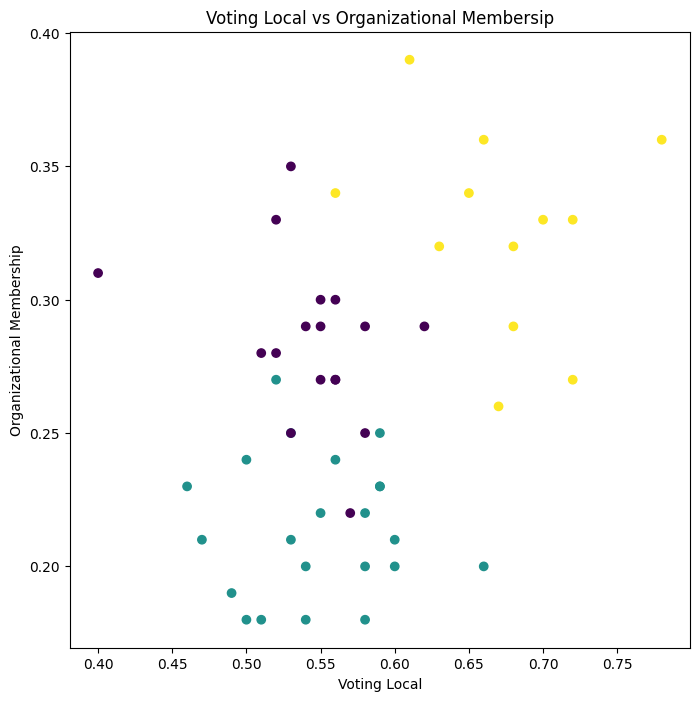

In [1124]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.scatter(cev['Voting_Local'], cev['Organizational_Membership'], c=cev['cluster_km'])
ax.set_xlabel('Voting Local')
ax.set_ylabel('Organizational Membership')
ax.set_title("Voting Local vs Organizational Membersip");